In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

from utils import *

%matplotlib inline

### <p style="text-align: center; color: green;">Motion Compensation Block Based</p>  

#### (A) Au TP1, vous avez réalisé de l’estimation de mouvement de type forward  par blocs entre F1 et F2. Procédez maintenant à de l’estimation backward par  blocs entre F1 et F2.

Reprenons notre code des séances précédentes afin d'appliquer la méthode block-wise.

In [2]:
OPTI_SLICING = 8
SEARCH_DIST_PIXEL = 4

BLOCK_LEN = 12
SEARCH_DIST_BLOCK = 18

LOOP_IMAGES = 1

In [3]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def estimate(deltaIntensity, dist):
    return 2 * deltaIntensity + dist / SEARCH_DIST_PIXEL

class Image:

    def __init__(self, pathImg):
        self.img = cv2.imread(pathImg)
        self.grayImage = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.height, self.width = self.grayImage.shape[:2]

    # (A) Block-wise
    def differenceBlockWise(self, other):
        vectors = np.zeros((self.height, self.width, 2))
        # Loop through all blocks
        for y in range(BLOCK_LEN//2, self.height, BLOCK_LEN):
            for x in range(BLOCK_LEN//2, self.width, BLOCK_LEN):
                # Get the block
                block = self.grayImage[y-BLOCK_LEN//2:y+BLOCK_LEN//2, x-BLOCK_LEN//2:x+BLOCK_LEN//2]
                # Make sure the block is the right size
                if block.shape != (BLOCK_LEN, BLOCK_LEN):
                    block = cv2.resize(block, (BLOCK_LEN, BLOCK_LEN))
                # Get the search area
                yMoves = np.arange(max(y-SEARCH_DIST_BLOCK, 0), min(y+SEARCH_DIST_BLOCK, self.height))
                xMoves = np.arange(max(x-SEARCH_DIST_BLOCK, 0), min(x+SEARCH_DIST_BLOCK, self.width))

                # Get the differences
                diff = np.zeros((len(yMoves), len(xMoves)))
                for i in range(len(yMoves)):
                    for j in range(len(xMoves)):
                        # Get the block in the search area
                        block2 = other.grayImage[max(yMoves[i]-BLOCK_LEN//2, 0):min(yMoves[i]+BLOCK_LEN//2, self.height), max(xMoves[j]-BLOCK_LEN//2, 0):min(xMoves[j]+BLOCK_LEN//2, self.width)]
                        # Make sure the blocks are the same size for border issues
                        if block2.shape != block.shape:
                            block2 = cv2.resize(block2, (BLOCK_LEN, BLOCK_LEN))
                        
                        # Get the difference using the estimation function
                        diff[i, j] = np.sum(2 * np.abs(block2 - block) + distance(x, y, xMoves[j], yMoves[i]))

                # Get the index of the minimum difference
                idx = np.unravel_index(np.argmin(diff, axis=None), diff.shape)
                # Get the vector
                vectors[y, x, 0] = (xMoves[idx[1]] - x)
                vectors[y, x, 1] = (yMoves[idx[0]] - y)
        return vectors

Appliquons l'estimation de mouvement à l'envers I2 -> I1

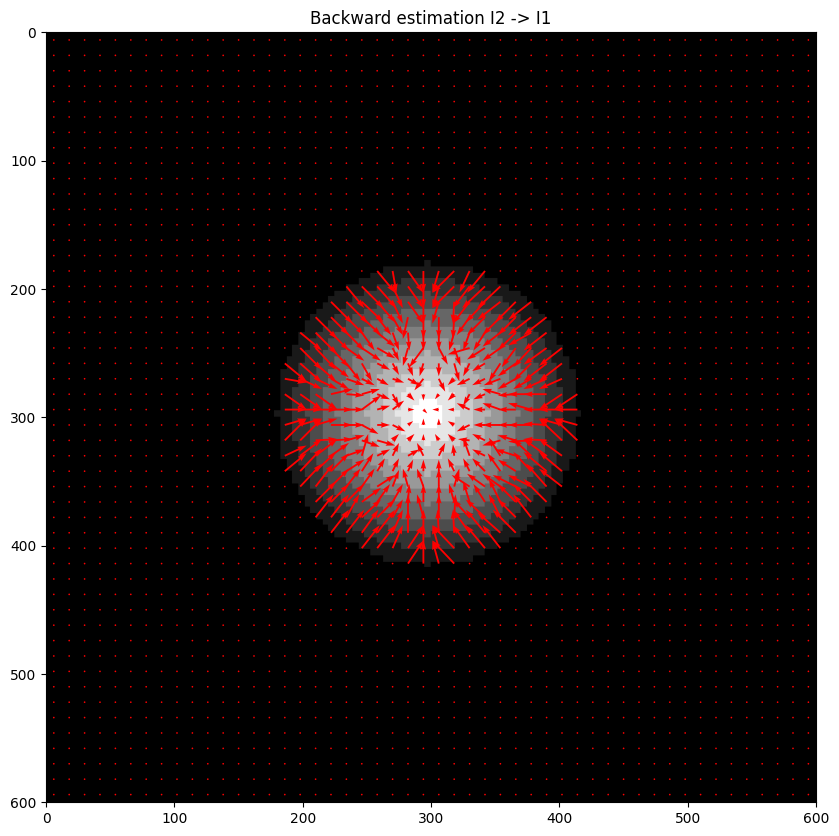

In [4]:
# create a new figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Charger les deux images
img1 = Image('1.png')
img2 = Image('2.png')

ax.clear()
ax.imshow(cv2.cvtColor(img2.img, cv2.COLOR_BGR2RGB))

# Calcul des vecteurs de mouvement
vectors = img2.differenceBlockWise(img1)

# draw the vectors using quiver
ax.quiver(np.arange(BLOCK_LEN // 2, img1.width, BLOCK_LEN), np.arange(BLOCK_LEN // 2, img1.height, BLOCK_LEN),
            vectors[BLOCK_LEN // 2::BLOCK_LEN, BLOCK_LEN // 2::BLOCK_LEN, 0], vectors[BLOCK_LEN // 2::BLOCK_LEN, BLOCK_LEN // 2::BLOCK_LEN, 1],
            angles='xy', scale_units='xy', scale=1, color='r')

# set the x and y limits of the plot
ax.set_xlim([0, img1.width])
ax.set_ylim([0, img1.height])
ax.set_title('Backward estimation I2 -> I1')

# Reverse the image
ax.invert_yaxis()

# show the plot
plt.show()

#### (B) Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1, pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ? Que se serait-il passé sinon ?

Il nous faut les vecteurs partant de la frame F2 pour pouvoir reconstruire celle-ci. Si nous prenions des vecteurs partant de la frame F1 avec la ME forward il y aurait un overlaps des blocs et donc des 'trous' dans la frame reconstruite causés par le fait que les blocs bougés par rapport aux vecteurs ne correspondront pas exactement aux blocs dans F2 . Alors que faire de la ME backward garantit en prenant l'opposé des vecteurs de faire bouger des blocs qui combleront l'image recomposée depuis F1.

#### (C) Reconstruisez l’image F2 à partir de vos vecteurs de mouvements et de F1. Quelle est la MSE de reconstruction ?

In [5]:
def compensation(vectors, img1, BLOCK_LEN):
    '''
        Compensate the image 2 from image 1 using the movement vectors 
    '''
    # Create a new image
    compensated = np.zeros((img1.height, img1.width, 3), dtype=np.uint8)
    # Loop through all the pixels
    for y in range(BLOCK_LEN//2, img1.height, BLOCK_LEN):
        for x in range(BLOCK_LEN//2, img1.width, BLOCK_LEN):
            compensated[y-BLOCK_LEN//2:y+BLOCK_LEN//2, x-BLOCK_LEN//2:x+BLOCK_LEN//2] = img1.img[
                y+vectors[y, x, 1]-BLOCK_LEN//2:y+vectors[y, x, 1]+BLOCK_LEN//2,
                x+vectors[y, x, 0]-BLOCK_LEN//2:x+vectors[y, x, 0]+BLOCK_LEN//2
            ]
    return compensated

In [6]:
def plotting3Axes(img1, img2, compensated):
    '''
        Plot the 3 images in 3 axes
    '''
    # create a new figure
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))

    # clear the axes
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    
    # show the images
    ax[0].imshow(cv2.cvtColor(img1.img, cv2.COLOR_BGR2RGB))
    ax[2].imshow(cv2.cvtColor(img2.img, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(compensated, cv2.COLOR_BGR2RGB))

    # set the titles
    ax[0].set_title('Image 1')
    ax[2].set_title('Image 2')
    ax[1].set_title('Compensated')

    # show the plot
    plt.show()

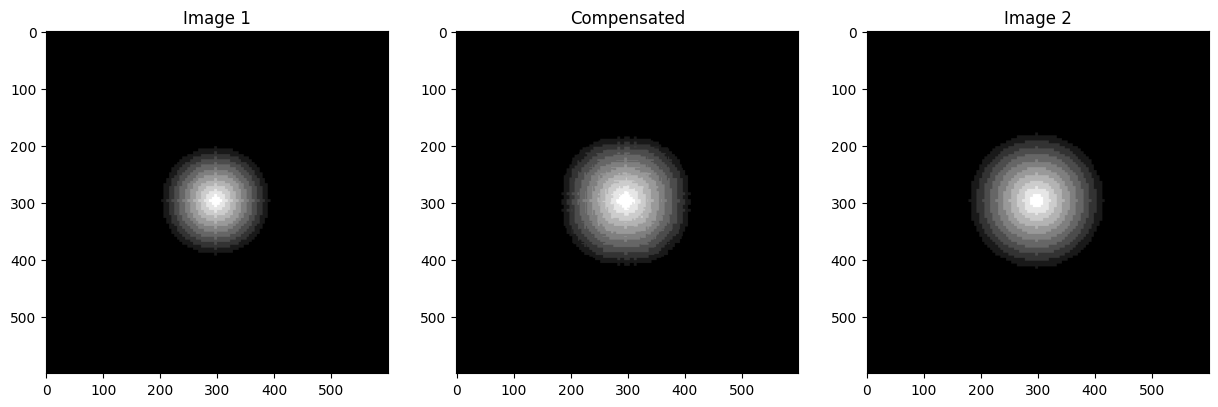

In [7]:
# Make sure the vectors are integers
vectors = vectors.astype(np.int32)
# Create a new img with the same shape as img2
img2_compensated = compensation(vectors, img1, BLOCK_LEN)

plotting3Axes(img1, img2, img2_compensated)

Here is the MSE between `img2` and `img2_compensated`

In [8]:
# Get the mean squared error between img2 and img2_compensated
mse = np.mean((img2.img - img2_compensated) ** 2)
print('MSE:', mse)

MSE: 2.2723305555555555


Regardons les différences d'intensité entre les 2 images en montrant l'image des différences

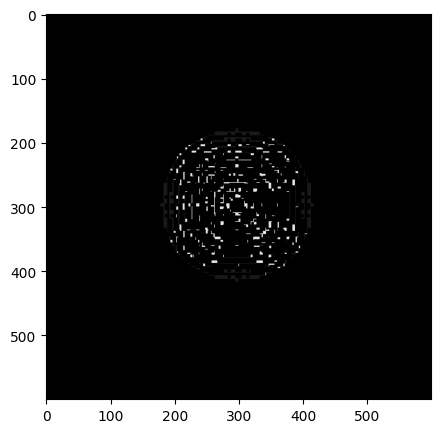

In [9]:
# Difference between img2 and img2_compensated
diff = img2.img - img2_compensated

# Create a new figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Draw the difference
ax.imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))

plt.show()

#### (D) Supposant que l’on n’aura plus accés à F2, quelles sont les 3 données ”classiques” (en plus du paramètres de taille de bloc) dont on a besoin pour la reconstruire de façon parfaite en compensation de mouvement ?

Les 3 données dont on aura besoin seront :

- Vecteurs de mouvement pour effectuer la compensation
- L'image I1
- Notre image de différence entre I2 et notre compensation de I2

#### (E) Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE de reconstruction ?

En utilisant seulement les 3 données décrites ci-dessus :

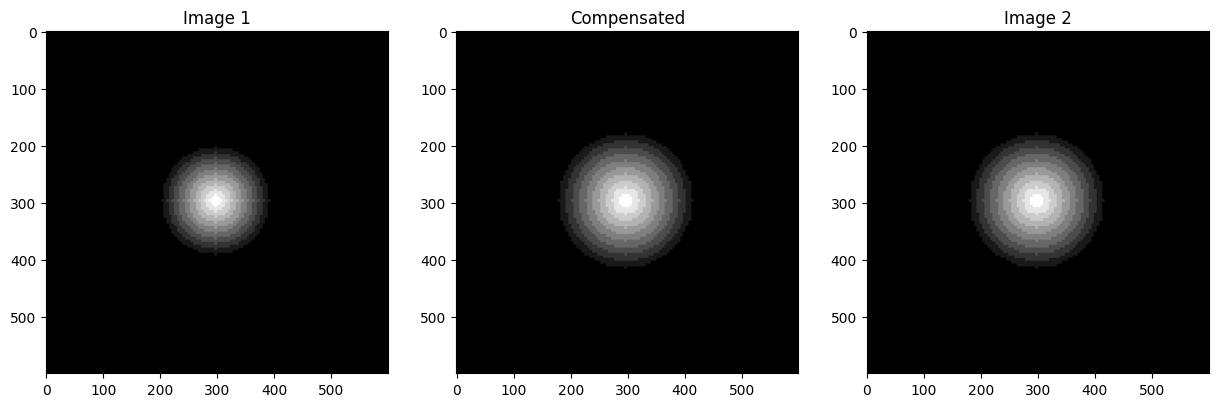

In [10]:
# Create the compensated image
img2_compensated = compensation(vectors, img1, BLOCK_LEN)
# Add the difference
img2_compensated = img2_compensated + diff

plotting3Axes(img1, img2, img2_compensated)

In [11]:
# Compute MSE
mse = np.mean((img2.img - img2_compensated) ** 2)
print('MSE:', mse)

MSE: 0.0


La MSE est maintenant nulle, nous avons une parfaite reconstruction de l'image 2 à partir des 3 données.

#### (F) Expliquez quelles données on peut coder avec perte pour garder une qualité de reconstruction de F1 et F2 ”correcte”. Justifiez vos explications par des images de rendus.

Essayons de limiter les données provenant de l'image de différence en éliminant les petites valeurs.

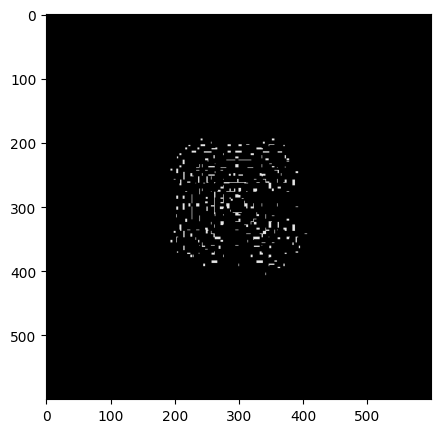

In [12]:
diff2 = diff.copy()
diff2[diff2 < 50] = 0

# Plot the difference
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(cv2.cvtColor(diff2, cv2.COLOR_BGR2RGB))
plt.show()

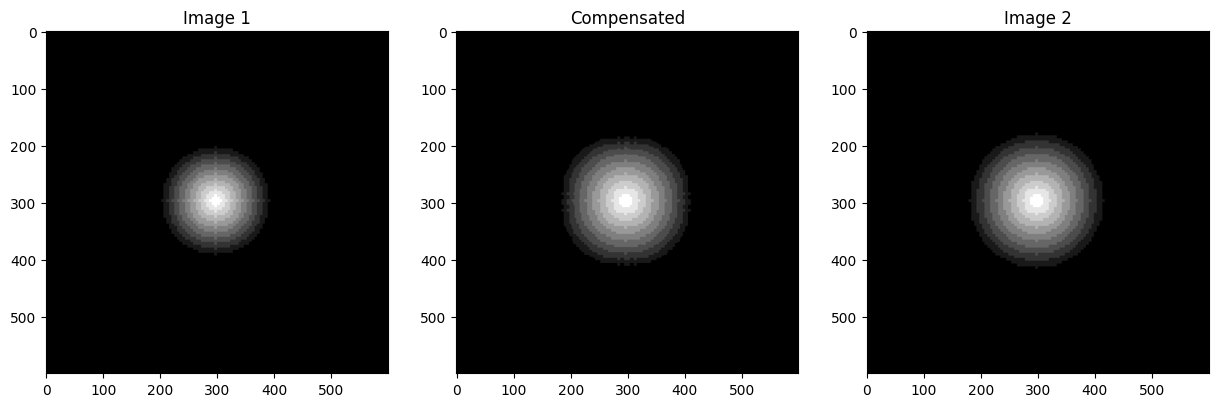

In [13]:
# Create the compensated image
compensated = compensation(vectors, img1, BLOCK_LEN)
# Add the difference
compensated = compensated + diff2

plotting3Axes(img1, img2, compensated)

In [14]:
# Compute MSE
mse = np.mean((img2.img - compensated) ** 2)
print('MSE:', mse)

MSE: 1.1768027777777779


Cette solution divise l'erreur (MSE) par deux entre la ressemblance de l'image compensé avec l'image réelle. Cependant, la perte d'informations semble trop visible.    
Nous allons maintenant essayer une quantification uniforme sur l'image d'erreur:

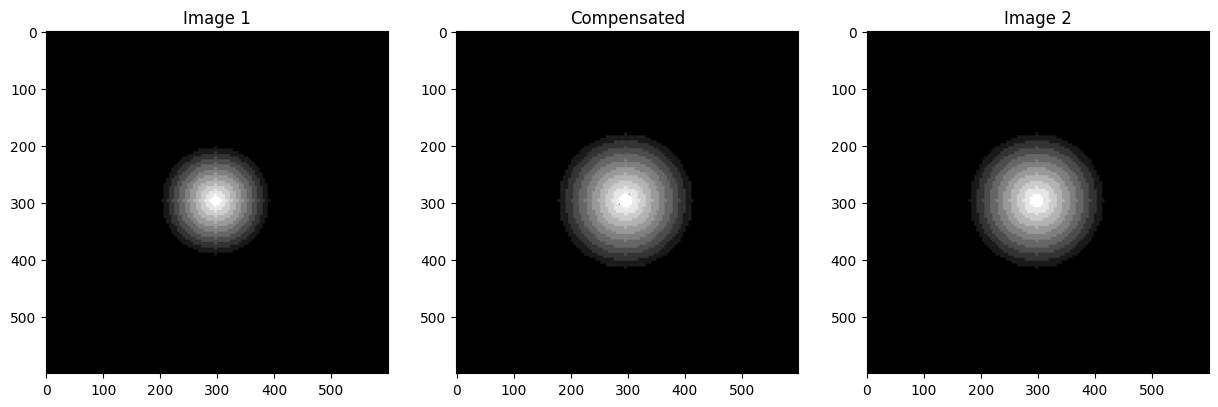

MSE: 0.9093638888888889


In [15]:
diff3 = diff.copy()
# Quantification uniforme
QUANT_STEP = 30
diff3 = np.round(diff3 / QUANT_STEP)
diff3 = diff3.astype(np.uint8)


# Create the compensated image with the (1)vectors (2)img1 (3)the quantified difference (4)quantification step
compensated = compensation(vectors, img1, BLOCK_LEN)
compensated = compensated + diff3 * QUANT_STEP

plotting3Axes(img1, img2, compensated)
mse = np.mean((img2.img - compensated) ** 2)
print('MSE:', mse)

L'approche semble être plus appropriée que la précédente, mais nous avons pris un taux de quantification au hasard essayons de voir quel taux de quantification serait le plus approprié en fonction de l'erreur:

In [16]:
def quantificationUniforme(diff, compensated_img, img2):
    '''
        Quantify the difference using uniform quantification and by
        choosing the correct step to find a compromise between MSE and compression
    '''
    diff2 = diff.copy()
    best_mse, best_step, coef = math.inf, 1, -math.inf
    # Choosing the step to minimize the MSE and maximize the compression
    for step in range(10, 255, 10):
        diff3 = np.round(diff.copy() / step) * step
        diff3 = diff3.astype(np.uint8)

        compensated = compensated_img + diff3
        mse = np.mean((img2.img - compensated) ** 2)

        diff_step, mse_step = step - best_step, abs(mse - best_mse)
        if mse_step == 0:
            mse_step = 1e-15
        if diff_step / mse_step > coef:
            coef = diff_step / mse_step
            best_mse = mse
            best_step = step
            diff2 = diff3
            print('Best MSE:', best_mse, 'Best step:', best_step, 'Coef:', coef)
    return (diff2 / step).astype(np.uint8), best_step

Best MSE: 0.2020861111111111 Best step: 10 Coef: 0.0
Best MSE: 0.9703083333333333 Best step: 20 Coef: 13.017066820943013
Best MSE: 0.9093638888888889 Best step: 30 Coef: 164.08386508659976
Best MSE: 1.7294972222222222 Best step: 170 Coef: 170.7039505771419
Best MSE: 1.8876194444444445 Best step: 240 Coef: 442.69552385636973


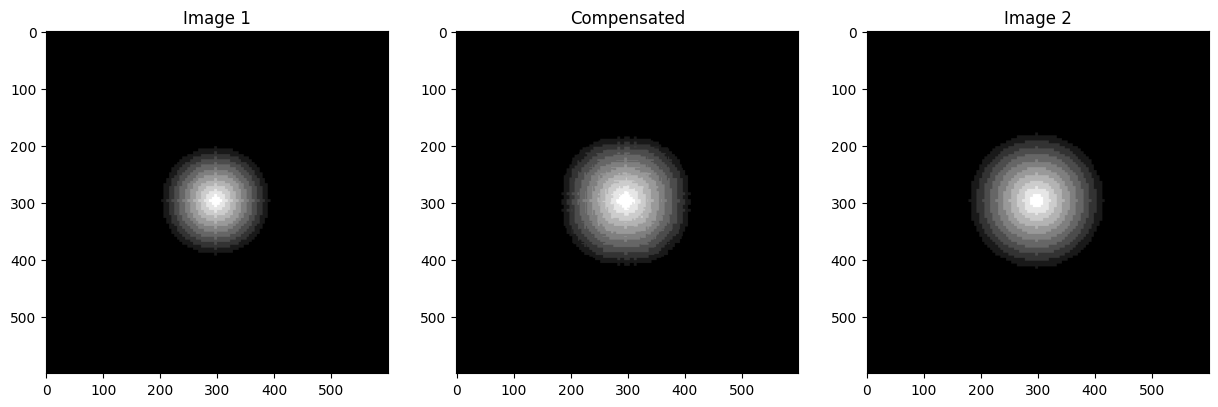

In [17]:
diff3, step = quantificationUniforme(diff, compensation(vectors, img1, BLOCK_LEN), img2)

# Create the compensated image with the (1)vectors (2)img1 (3)the quantified difference (4)quantification step
compensated = compensation(vectors, img1, BLOCK_LEN)
compensated = compensated + diff3 * step
plotting3Axes(img1, img2, compensated)

Enfin, un pas de quantification de 240 est le meilleur compromis entre compression et réduction de l'erreur quadratique moyenne. Si l'on veut une erreur plus basse il sera plus prudent de choisir un pas de 30 ou de 10 (meilleur coef pour basse compression) car un choix au dessus augmente rapidement l'erreur.

#### (G) Qu’est-ce-qui aurait changé si on utilise une méthode à base de mesh du point de vue de la minimisation ? et du point de vue du rendu final ? Montrez vos résultats en vous aidant du TP1.

La méthode à base de mesh mouvoie les nodes seulement, au lieu de bloc entier. Ce qui veut dire que le mouvement des pixels à l'intérieur d'un bloc auront potentiellement un mouvement différent selon la différence de positionnement des nodes après la descente de gradients. Cela devrait aider la minimisation de l'erreur.  
Pour avoir la meilleur minimisation possible il faut réduire la taille des blocs pour avoir une idée précise des mouvements. Cependant, plus notre taille de bloc est bas et moins le mouvement des nodes est grand, empêchant le mouvement des pixels vers leur place convenable de compensation. Ceci est impliqué par notre méthode de descente du gradient. Pour garder une MSE basse il nous faut donc choisir une taille de bloc assez grande, ici on choisira une taille de `60` divisant l'image en 10x10.

Dans `utils.py` se trouve nos méthodes créées dans le notebook appliquant la méthode Mesh Based. Reprenons ces méthodes en faisant de la ME backward:

100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


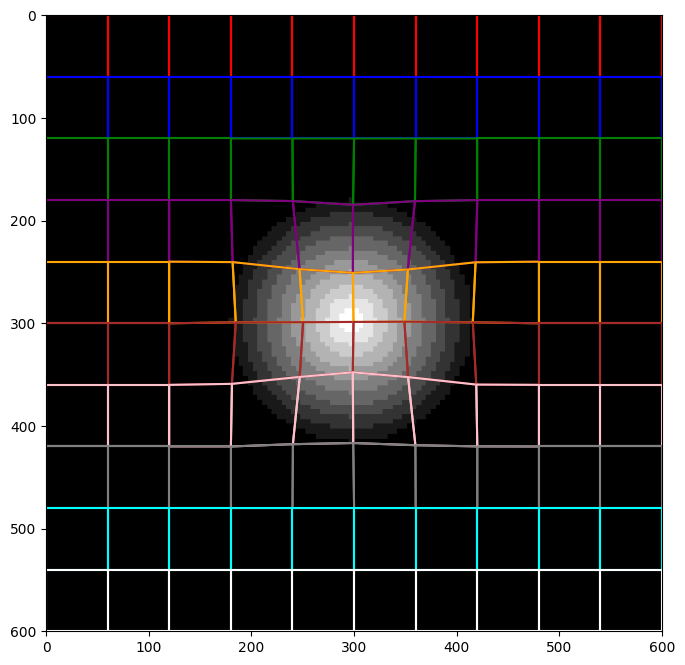

In [18]:
allNodes = getNodesDisplacement(img2.grayImage, img1.grayImage)

# Create a figure and axis object
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img2.grayImage, cmap='gray')

# Plot the polygons
for i in range(len(allNodes)):
    node = plt.Polygon(allNodes[i], fill=False, edgecolor=colors[i % len(colors)], linewidth=1.5)
    ax.add_patch(node)

# Set the limits of the plot
ax.set_xlim(0, img2.width)
ax.set_ylim(img2.height, 0)

plt.show()

In [19]:
# Loop over all the nodes then loop over all the points of the node and recreate an image
img_mesh_backward = np.zeros((img2.height, img2.width, 3), dtype=np.uint8)
mesh_backward_vectors = np.zeros((img2.height, img2.width, 2), dtype=np.int32)

blocks = getBlocksCoordinates(img2.grayImage)
for indNodes, nodes in enumerate(allNodes):
    block = blocks[indNodes]
    phi1, phi2, phi3, phi4 = getInterpolation(block)
    for x in range(block[0][0], block[2][0]):
        for y in range(block[0][1], block[2][1]):
            vx, vy = phi1(x, y) * (block[0] - nodes[0]) + phi2(x, y) * (block[1] - nodes[1]) + phi3(x, y) * (block[2] - nodes[2]) + phi4(x, y) * (block[3] - nodes[3])
            mesh_backward_vectors[x,y] = [vx, vy]
            new_x, new_y = (int)(x + vx), (int)(y + vy)
            if new_x < 0:
                new_x = 0
            if new_y < 0:
                new_y = 0
            if new_x >= img2.height:
                new_x = img2.height - 1
            if new_y >= img2.width:
                new_y = img2.width - 1
            img_mesh_backward[x,y] = img2.img[new_x, new_y]

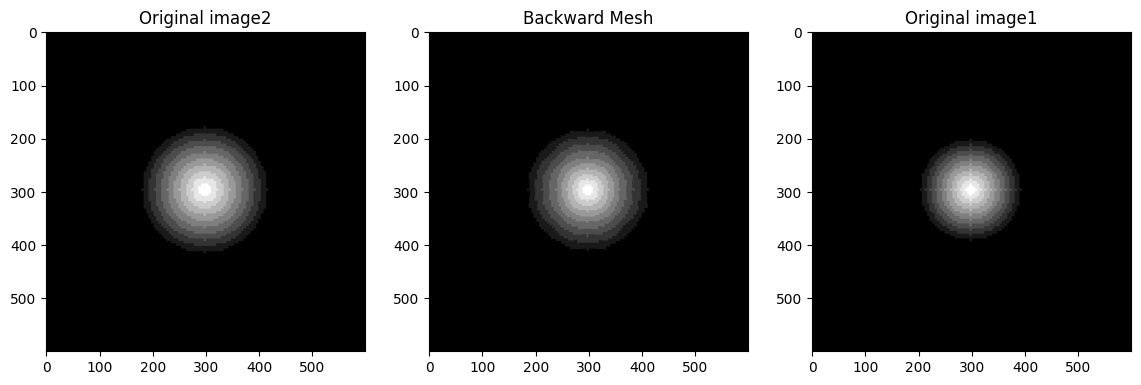

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(14, 14))
ax[0].imshow(cv2.cvtColor(img2.img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(img_mesh_backward, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(img1.img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original image2')
ax[1].set_title('Backward Mesh')
ax[2].set_title('Original image1')
plt.show()

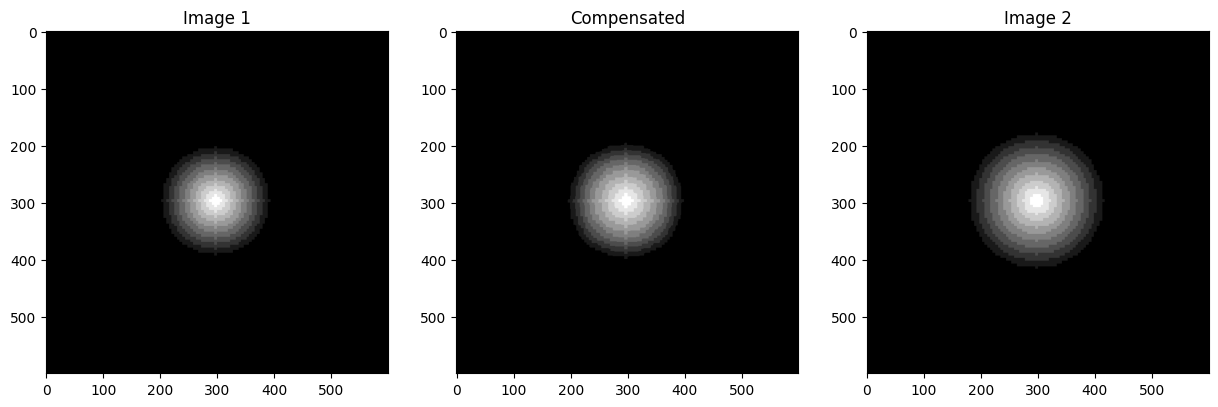

In [21]:
# Now we will use the mesh_backward_vectors to start the compensation on img1 to get img2
def compensatedMesh(img1, mesh_backward_vectors):
    compensated_mesh = np.zeros((img1.height, img1.width, 3), dtype=np.uint8)
    for x in range(img1.height):
        for y in range(img1.width):
            new_x, new_y = (int)(x - mesh_backward_vectors[x,y][0]), (int)(y - mesh_backward_vectors[x,y][1])
            if new_x < 0:
                new_x = 0
            if new_y < 0:
                new_y = 0
            if new_x >= img2.height:
                new_x = img2.height - 1
            if new_y >= img2.width:
                new_y = img2.width - 1
            compensated_mesh[x,y] = img1.img[new_x, new_y]
    return compensated_mesh

compensated_mesh = compensatedMesh(img1, mesh_backward_vectors)

plotting3Axes(img1, img2, compensated_mesh)

In [22]:
# Get MSE between img2 and compensated_mesh
mse = np.mean((img2.img - compensated_mesh) ** 2)
print('MSE:', mse)

MSE: 9.75645


Au final on se rend compte que la MSE est plus grande en utilisant la méthode mesh-based comparé à bloc-based. Le rendu de l'image compensé donne une impression que l'image ne s'étend pas assez sur les bords (en référence à l'écartement entre img1 et img2). Une erreur est peut-être à prévoir dans le code car le mouvement des pixels selon leur interpolation et descente de gradient est plus faible que ce qu'il ne devrait.

Voyons l'image de différence et appliquons l'algorithme de compensation pour retrouver l'image 2.

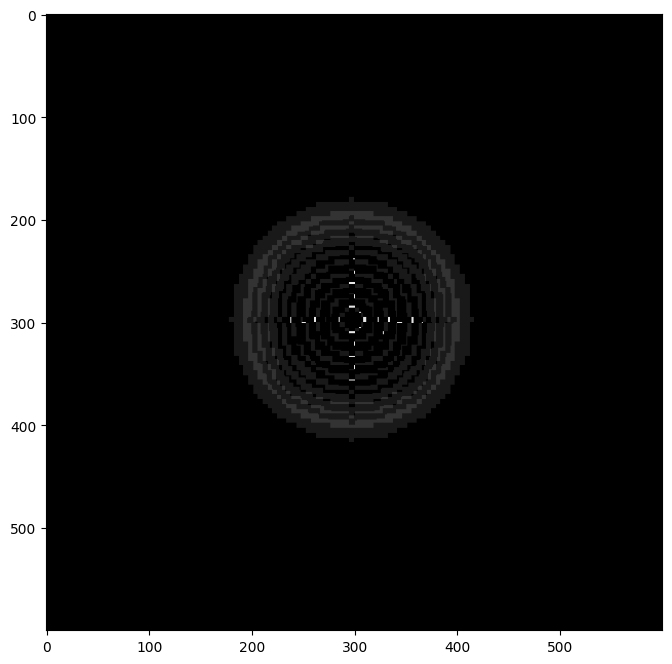

In [23]:
# Compute the difference between img2 and compensated_mesh
diff = img2.img - compensated_mesh

# plot the difference
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
plt.show()

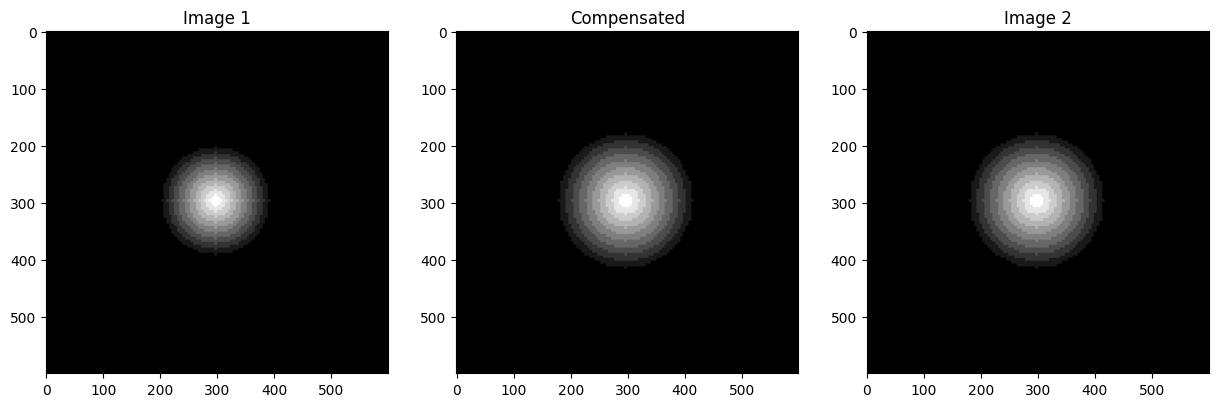

MSE: 0.0


In [24]:
# Create the compensated image of img2 with the (1)backward_vectors (2)img1 (3) diff image
compensated_mesh = compensatedMesh(img1, mesh_backward_vectors)
img2_compensated = compensated_mesh + diff

plotting3Axes(img1, img2, img2_compensated)
mse = np.mean((img2.img - img2_compensated) ** 2)
print('MSE:', mse)

Ici nous sommes obligés de mettre plus d'informations dans l'image de différence afin de récupérer l'image 2. Essayons tout de même d'appliquer la quantification uniforme :

Best MSE: 1.4805722222222222 Best step: 10 Coef: 0.0
Best MSE: 3.39885 Best step: 20 Coef: 5.213009354455675
Best MSE: 2.8771833333333334 Best step: 30 Coef: 19.169329073482434
Best MSE: 9.739838888888888 Best step: 170 Coef: 20.40026617490152
Best MSE: 9.74333888888889 Best step: 180 Coef: 2857.1428571422657
Best MSE: 9.748672222222222 Best step: 220 Coef: 7500.000000000826
Best MSE: 9.751394444444445 Best step: 250 Coef: 11020.408163261425


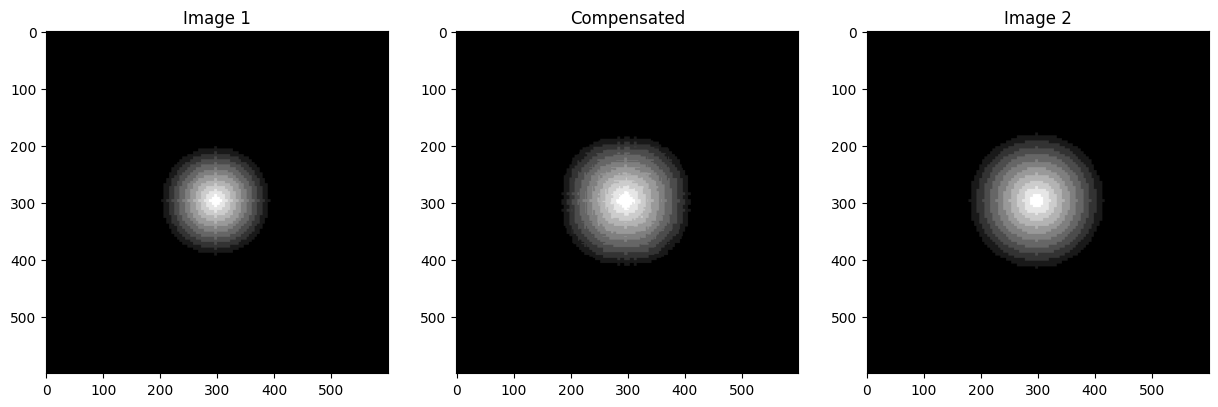

In [25]:
# Quantif uniforme
diff2, step = quantificationUniforme(diff, compensatedMesh(img1, mesh_backward_vectors), img2)

# Create the compensated image with the (1)vectors (2)img1 (3)the quantified difference (4)quantification step
compensated_mesh2 = compensatedMesh(img1, mesh_backward_vectors)
compensated_mesh2 = compensated_mesh2 + diff2 * step
plotting3Axes(img1, img2, compensated)

Finalement, en utilisant la méthode mesh-based si l'on veut réduire l'erreur au maximum en gardant une quantification nous pouvons choisir un pas de 10 dans la quantification uniforme. A l'inverse, si l'on veut quantifier au maximum nous pouvons choisir un pas de 30 ou un pas de 250 (max). Il y aura tout de même un grand écart de précision entre les deux quantifications.

Conclusion :  

Une compression utilisant la méthode bloc-based avec une quantification uniforme utilisant un pas de 30 semble être le meilleur choix pour les images 1 et 2.